License: LGPLv3

# ChIP-Seq Downstream Analyses

In this notebook, we will actually we using R to analyze and visualize data. Unfortunately, we do not
have time to do an introduction to the R environment and programming language; however, there are several
source online to learn. If you are familiar with SAS, SPSS, Stata, etc., [Quick-R](http://www.statmethods.net/)
may be a good place to start. Another R package that I have heard good things about for learning is [swirl](http://swirlstats.com/)

## Background

We have already analyzed our sequencing data and produced a set of peaks for downstream analysis.
Here, we will focus on annotating the peaks and some functional enrichment.

We will use the [ChIPSeeker](http://bioconductor.org/packages/release/bioc/html/ChIPseeker.html) BioconductoR package. This package has lots of easy to use functions for visualizing, plotting, and even enrichment analyses.
We will only highlight the main functions here, but please explore the link above for more examples and information. 

> G Yu, LG Wang, QY He.
ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization.
Bioinformatics 2015, 31(14):2382-2383.

We will use the pre-analyzed full dataset for this workshop; however, and bed or narrowPeak file
should work with this package. In addition, some of these steps take a while to run. For the sake of
time, I have already run these steps and saved the results as an R object which we will load. I still provide 
the commented out source code so you can understand how these R objects were created.

## Set up

First, we will load the necessary R libraries the peak files into R. 

In [1]:
# Load the libraries
# These will need to be installed already
suppressMessages(require(ChIPseeker))
suppressMessages(require(TxDb.Hsapiens.UCSC.hg38.knownGene))
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

# Set up the input files. I hardcoded the directory path
# that contains all the narrowPeak files. We then create
# a list where each item is the treatment group and the path
# to the narrowPeak file
idir <- "/home/ubuntu/data/chipseq/fullset/peaks"
files <- list("Ab1"=file.path(idir, "Ab1.filtered.intersected.narrowPeak"),
              "RNAPII"=file.path(idir, "RNAPII.filtered.intersected.narrowPeak"))

# Look at the files list
print("Files list:")
files

# Now, we use the readPeakFile() function that is provided by
# the ChIPseeker package. We use the lapply function so that we
# can easily loop over the files list and load in the peaks.
peaks <- lapply(files, function(x) readPeakFile(x, header=FALSE))

# There should be 2 elements in the list that are identified by the
# treatment name.
print("Peak list names:")
names(peaks)

# We can peek at one of the treatment's peak data
print("Peak data from Ab1:")
peaks$Ab1

[1] "Files list:"


$Ab1
[1] "/home/ubuntu/data/chipseq/fullset/peaks/Ab1.filtered.intersected.narrowPeak"

$RNAPII
[1] "/home/ubuntu/data/chipseq/fullset/peaks/RNAPII.filtered.intersected.narrowPeak"

[1] "Peak list names:"


[1] "Ab1"    "RNAPII"

[1] "Peak data from Ab1:"


GRanges object with 7346 ranges and 7 metadata columns:
         seqnames                 ranges strand |                   V4
            <Rle>              <IRanges>  <Rle> |             <factor>
     [1]    chr10     [ 134356,  134899]      * |  Ab1.input_peak_2206
     [2]    chr10     [1489238, 1489661]      * |  Ab1.input_peak_2215
     [3]    chr10     [2987846, 2988081]      * |  Ab1.input_peak_2226
     [4]    chr10     [3172410, 3172896]      * |  Ab1.input_peak_2231
     [5]    chr10     [3810133, 3810393]      * |  Ab1.input_peak_2236
     ...      ...                    ...    ... .                  ...
  [7342]     chrX [154762498, 154762833]      * | Ab1.input_peak_29547
  [7343]     chrX [154805120, 154805605]      * | Ab1.input_peak_29548
  [7344]     chrX [155026792, 155027037]      * | Ab1.input_peak_29549
  [7345]     chrX [155263928, 155264220]      * | Ab1.input_peak_29550
  [7346]     chrX [155264331, 155264568]      * | Ab1.input_peak_29551
                V5   

Basically, R took our narrowPeak files and converted them into a GRanges object.
If you are unfamiliar with what GRange objects are, they are an R data type that is
commonly used in BioconductoR packages to hold region-based genomic data. They are a part
of the [GenomicRanges](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html) package 
which has several guides on their usage.

Now that we have out data inside R, we can start looking at various plots.

## Coverage plots

To get a global view of the peak locations over the whole genome, the `covplot` function 
visualizes the peak regions over all chromosomes. We will plot both factors together. 

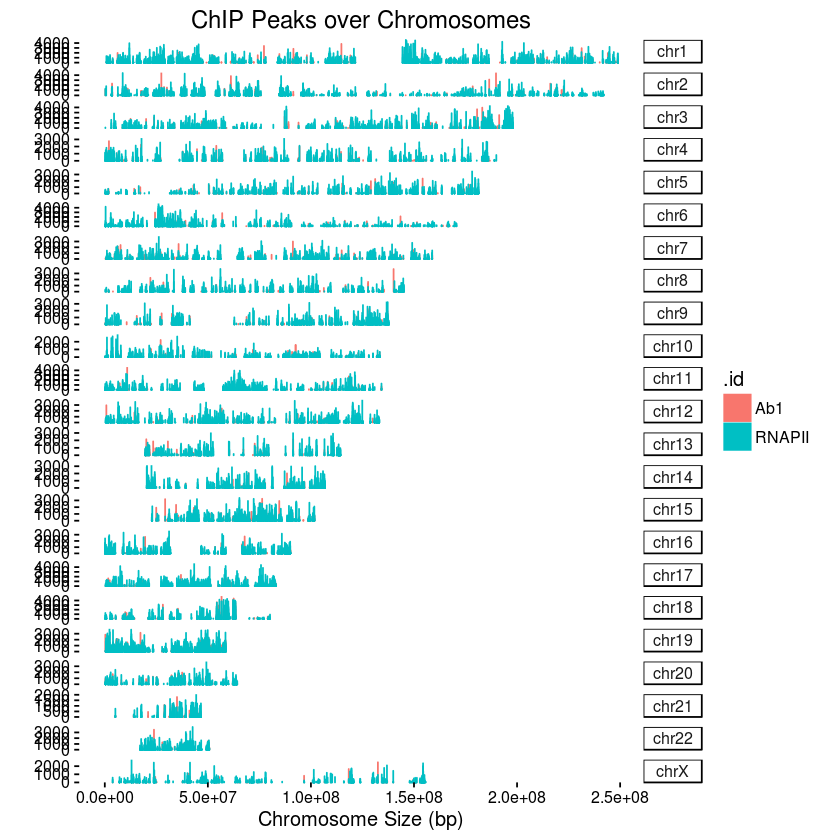

In [2]:
# This plot takes a moment
covplot(peaks, weightCol="V5")

## Tag Heatmap

To visualize the profile of ChIP peaks binding to TSS regions, ChIPseeker provides the `tagHeatmap` function. However, the input for this function is a `tagMatrix` which takes several minutes to create, so we will instead load the pre-computed `tagMatrix` into R before plotting. I do provide the steps to create the dataset and they are commented out.

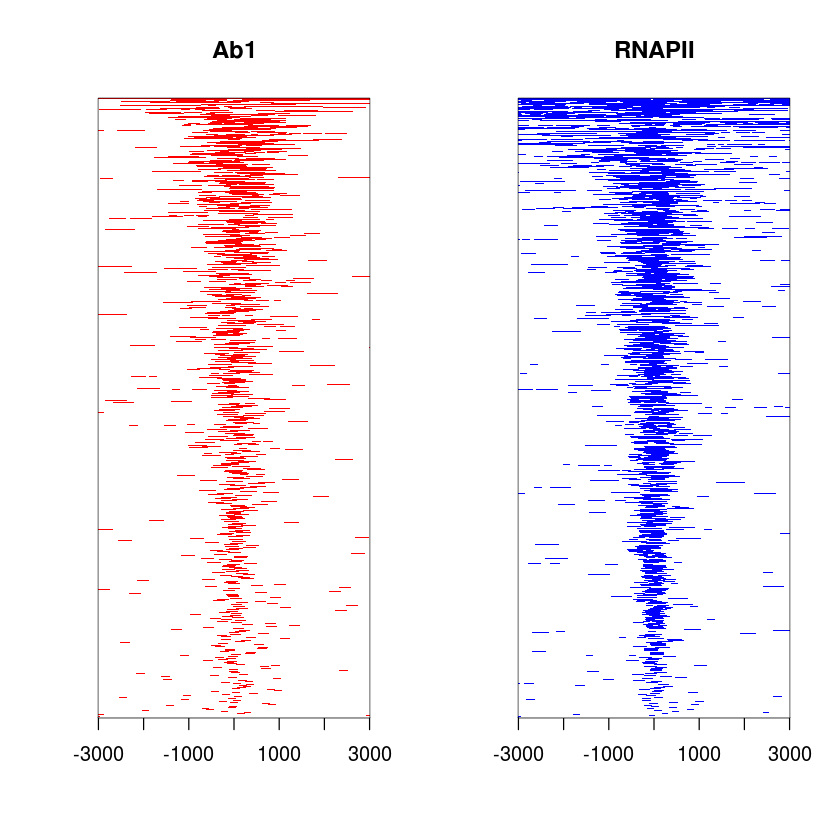

In [3]:
## We first need to create a tagMatrix which requires us to provide the
## locations of the promoters. Fortunately, we can use the getPromoters function
## with the TxDb object
#
# promoter <- getPromoters(TxDb=txdb, upstream=3000, downstream=3000)
#
## Next, we can make the tagMatrix using the lapply function and our peak list
# tagMatrix <- lapply(peaks, function(x) getTagMatrix(x, windows=promoter))

# Since we already pre-computed the tag matrix, we will load it here
load(file.path(idir, "Rdata", "tagMatrix.Rdata"))

# Finally, we can make our tag heatmap
tagHeatmap(tagMatrix, xlim=c(-3000, 3000), color=c("red", "blue"))

## Profile plot

Another way to visualize the binding profile from the `tagMatrix` is to use the `plotAvgProf` function. There are even options to perform bootstrapping to estimate
confidence intervals which we will not cover here.

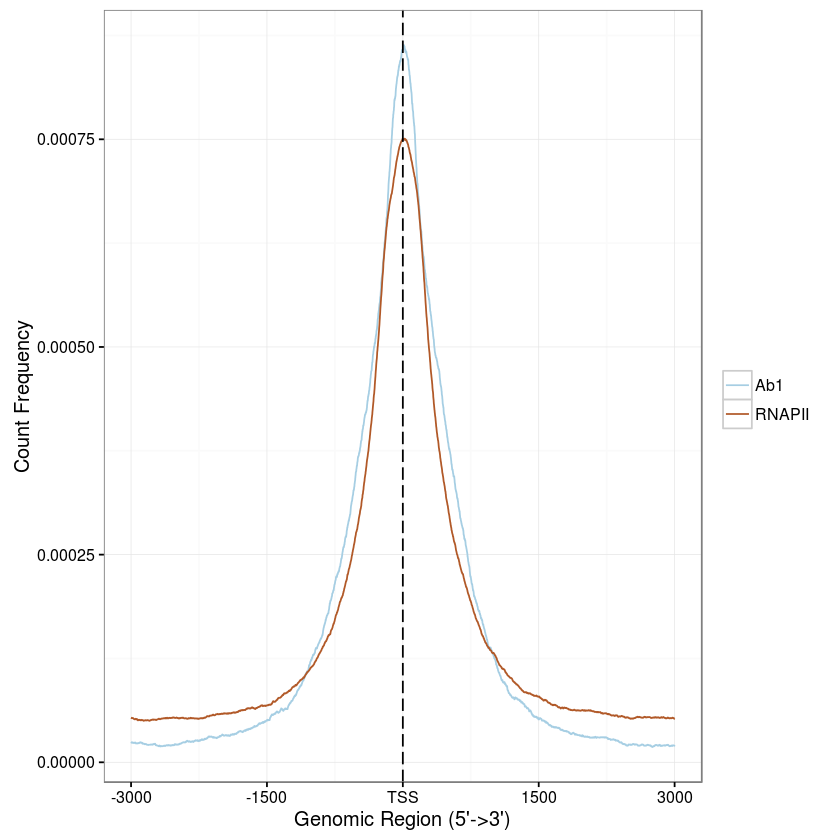

In [4]:
# Plot the average profile
plotAvgProf(tagMatrix, xlim=c(-3000, 3000), 
            xlab="Genomic Region (5'->3')", 
            ylab="Count Frequency")

## Annotate Peaks

Now that we have looks at some basic plots of our ChIP-Seq peaks, we will move on to
annotating our data. Essentially we want to lookup the gene with the closest TSS to our
peaks and get the genomic feature where our peak is located (e.g., promoter region, 5'UTR, intergenic, etc.). To do this, we will use the `annotatePeak` function from ChIPseeker. This function can take some time, so we will again load the pre-computed results.

In [5]:
## We will apply the annotatePeak function to every peak set in our
## peak list using the lapply method
#
# peakAnnoList <- lapply(peaks, annotatePeak, TxDb=txdb, 
#                       tssRegion=c(-3000, 3000),
#                       annoDb="org.Hs.eg.db", verbose=FALSE)

# Since we are not computing this here, we will load the pre-computed dataset
load(file.path(idir, "Rdata", "peakAnnoList.Rdata"))

# If we peek at the Ab1 data, we will get a nice summary.
print("Summary of Ab1 annotation:")
peakAnnoList$Ab1

[1] "Summary of Ab1 annotation:"


Annotated peaks generated by ChIPseeker
7346/7346  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (1-2kb)  3.8115981
10   Promoter (<=1kb) 79.1451130
11   Promoter (2-3kb)  1.3204465
4              5' UTR  0.3130956
3              3' UTR  0.8031582
1            1st Exon  0.4356112
7          Other Exon  1.5654778
2          1st Intron  1.4429622
8        Other Intron  2.9131500
6  Downstream (<=3kb)  0.4219984
5   Distal Intergenic  7.8273891

To actually extract the annotation from the `peakAnnoList` into an Excel-like tabular
format, you first need to convert it to a `data.frame` using the very convenient 
`as.data.frame()` function. Once you do that, you can use
the built-in R functions (e.g., `write.table()`) to save it to your disk. You will need
to do this for each element in your `peakAnnoList` separately. Here, I will just print
the first few lines of the annotation data to the screen so you can see what kind of
data is present.

In [6]:
# Showing how to convert to data.frame and printing the first few rows of data
print("First few rows of Ab1 annotation data:")
head(as.data.frame(peakAnnoList$Ab1))

# The column names in the annotation data
print("Column names")
names(as.data.frame(peakAnnoList$Ab1))

[1] "First few rows of Ab1 annotation data:"


seqnames,start,end,width,strand,V4,V5,V6,V7,V8,⋯,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
chr10,134356,134899,544,*,Ab1.input_peak_2206,43,.,4.36979,7.02482,⋯,134465,254637,120173,1,10771,uc010pzu.2,0,ENSG00000015171,ZMYND11,zinc finger MYND-type containing 11
chr10,1489238,1489661,424,*,Ab1.input_peak_2215,51,.,4.06589,7.85770,⋯,1526630,1556984,30355,1,642394,uc001ign.3,-36969,ENSG00000205696,ADARB2-AS1,ADARB2 antisense RNA 1
chr10,2987846,2988081,236,*,Ab1.input_peak_2226,82,.,6.47981,11.24631,⋯,3067520,3136805,69286,1,5214,uc001igp.3,-79439,ENSG00000067057,PFKP,"phosphofructokinase, platelet"
chr10,3172410,3172896,487,*,Ab1.input_peak_2231,109,.,5.36279,14.11020,⋯,3136924,3172841,35918,2,10531,uc001igr.2,0,ENSG00000107959,PITRM1,pitrilysin metallopeptidase 1
chr10,3810133,3810393,261,*,Ab1.input_peak_2236,28,.,3.74553,5.43989,⋯,3775996,3785281,9286,2,1316,uc001iha.3,-24852,ENSG00000067082,KLF6,Kruppel-like factor 6
chr10,5665920,5666392,473,*,Ab1.input_peak_2242,324,.,12.79724,36.38798,⋯,5638857,5666595,27739,2,79754,uc001iig.2,203,ENSG00000196372,ASB13,ankyrin repeat and SOCS box containing 13


[1] "Column names"


[1] "seqnames"      "start"         "end"           "width"        
 [5] "strand"        "V4"            "V5"            "V6"           
 [9] "V7"            "V8"            "V9"            "V10"          
[13] "annotation"    "geneChr"       "geneStart"     "geneEnd"      
[17] "geneLength"    "geneStrand"    "geneId"        "transcriptId" 
[21] "distanceToTSS" "ENSEMBL"       "SYMBOL"        "GENENAME"

Now that we have our annotations, we will showcase some of the nice visualization
tools that are present in the ChIPseeker package.

### Pie and bar plots for genomic annotation

We often recommend using bar plots over pie charts; however, both options are available.

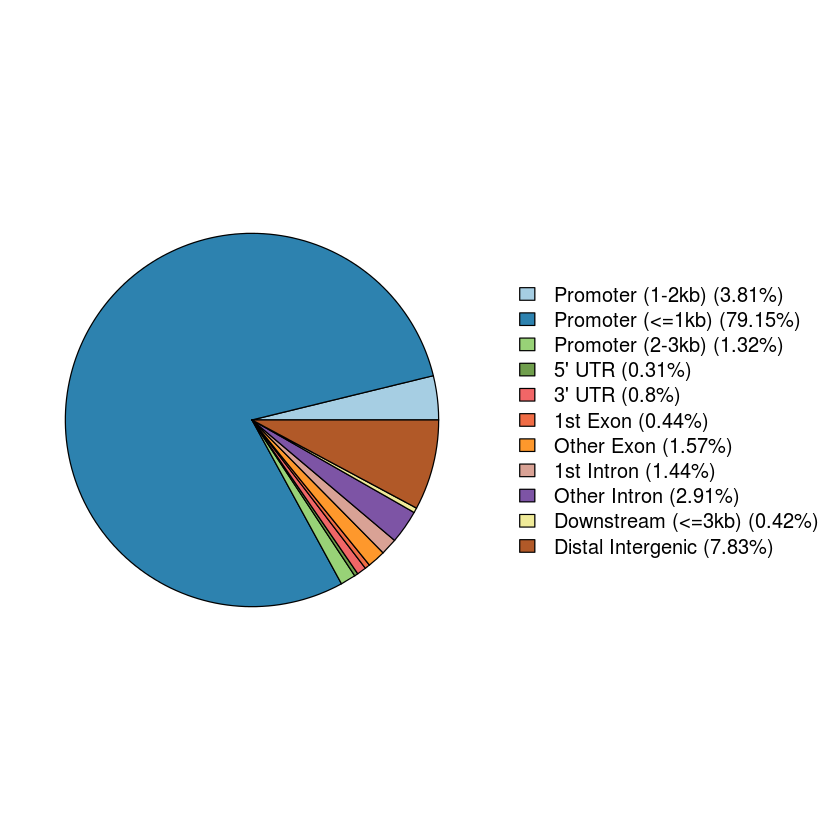

In [7]:
# Plot annotation pie chart. Note: This only allows you to plot
# a single annotated peak set at a time
plotAnnoPie(peakAnnoList$Ab1)

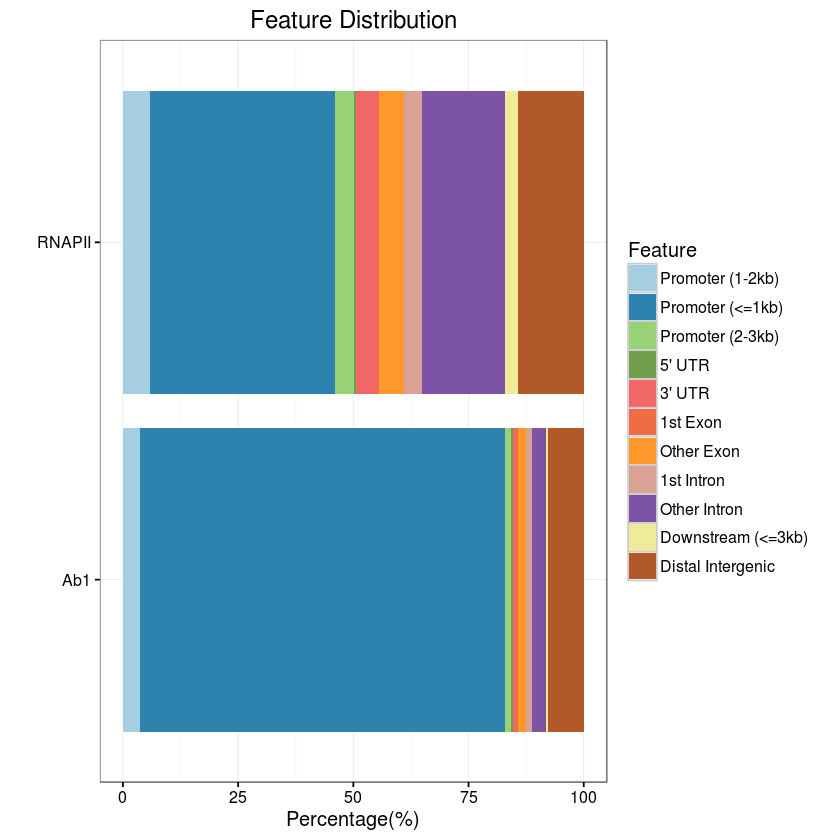

In [8]:
# The barchart allows you to plot multiple samples, so
# you can pass the peakAnnoList
plotAnnoBar(peakAnnoList)

We clearly see that a lot of our peaks are located in the promoter region; however, this is more apparent in the Ab1 factor.

There are some other plots for viewing the genomic annotation which you can explore on your own time.

### The distribution of binding loci relative to the TSS

As we saw in the annotation output one of the columns provides the distrance to the nearest
TSS. We can visualize the distribution of these distances using the `plotDistToTSS()` function.

Warning message:
“Stacking not well defined when ymin != 0”

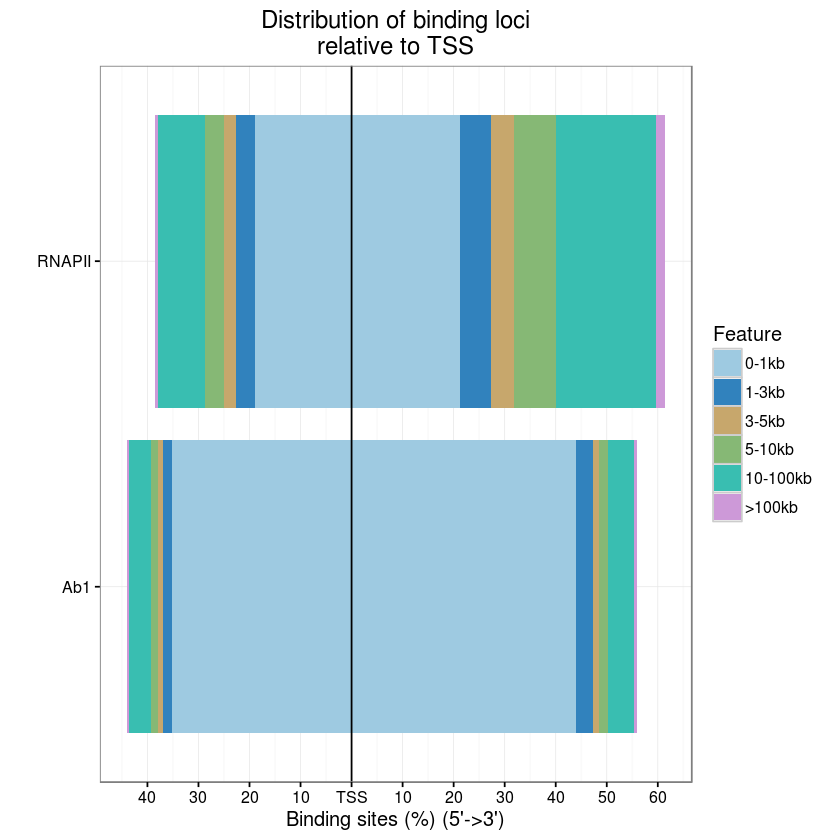

In [9]:
# Plot distribution of peak distance to TSS. This plot does allow
# multiple peak sets, so we can pass the peakAnnoList
plotDistToTSS(peakAnnoList, 
              title="Distribution of binding loci\nrelative to TSS")

Here we can see that most of our peaks are near the TSS site.

## Functional enrichment analysis

Now that we have annotated out peaks, we can use ChIPseeker and another BioconductoR package called [clusterProfiler](http://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) to explore
and visualize functional enrichment. This package uses [DOSE](http://bioconductor.org/packages/release/bioc/html/DOSE.html) and [ReactomePA](http://bioconductor.org/packages/release/bioc/html/ReactomePA.html) to perform
a multitude of ernrichment tests.

> Yu G, Wang L, Han Y and He Q (2012). “clusterProfiler: an R package for comparing biological themes among gene clusters.” OMICS: A Journal of Integrative Biology, 16(5), pp. 284-287.

Due to complexities with linking genomic regions to genes in a many-to-many mapping, ChIPseeker provides a the `seq2gene` function to link both coding and non-coding genomic regions to coding
genes and facilitate functional analysis. So, before we begin we will first pass our
peak datasets through this function.

In [10]:
# Load the clusterProfiler package
suppressMessages(require(clusterProfiler))

# Use the seq2gene function to make gene lists for functional analysis
# Notice that we are passing the original, unannotated peak data
genes.ab1 <- seq2gene(peaks$Ab1, tssRegion = c(-3000, 3000), flankDistance=3000, TxDb=txdb)
genes.rnapii <- seq2gene(peaks$RNAPII, tssRegion = c(-3000, 3000), flankDistance=3000, TxDb=txdb)

# Next, we will create a list containing these gene lists
geneList <- list("Ab1"=genes.ab1, "RNAPII"=genes.rnapii)

Now that we have our gene list, I will briefly show you how to run pathway enrichment and
GO enrichment. Since these take some time to run, we will load the pre-computed results. There are several options to these tests which we will not have time to go over but are available in the links I provided above.

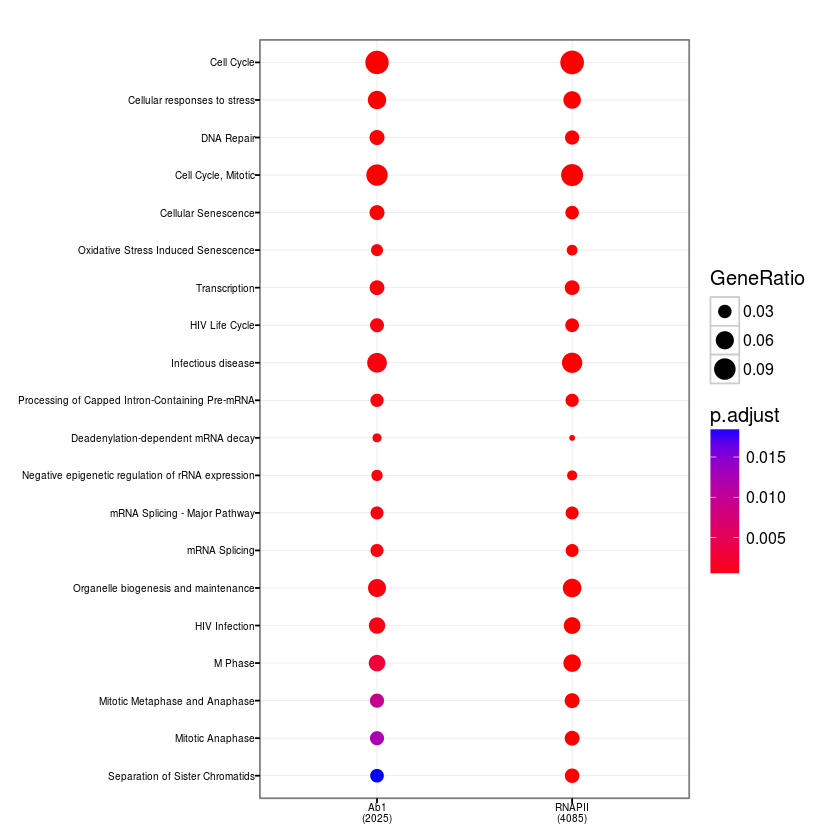

In [18]:
## Reactome Pathway enrichment
## We use the compareCluster function with the enrichPathway method
#
# pathway.res <- compareCluster(geneList, fun = "enrichPathway")

# Since we have pre-computed results we need to load them
load(file.path(idir, "Rdata", "pathway.res.Rdata"))

# Now, we plot the top 15 pathways from each peak set
dotplot(pathway.res, showCategory=15, font.size=6)

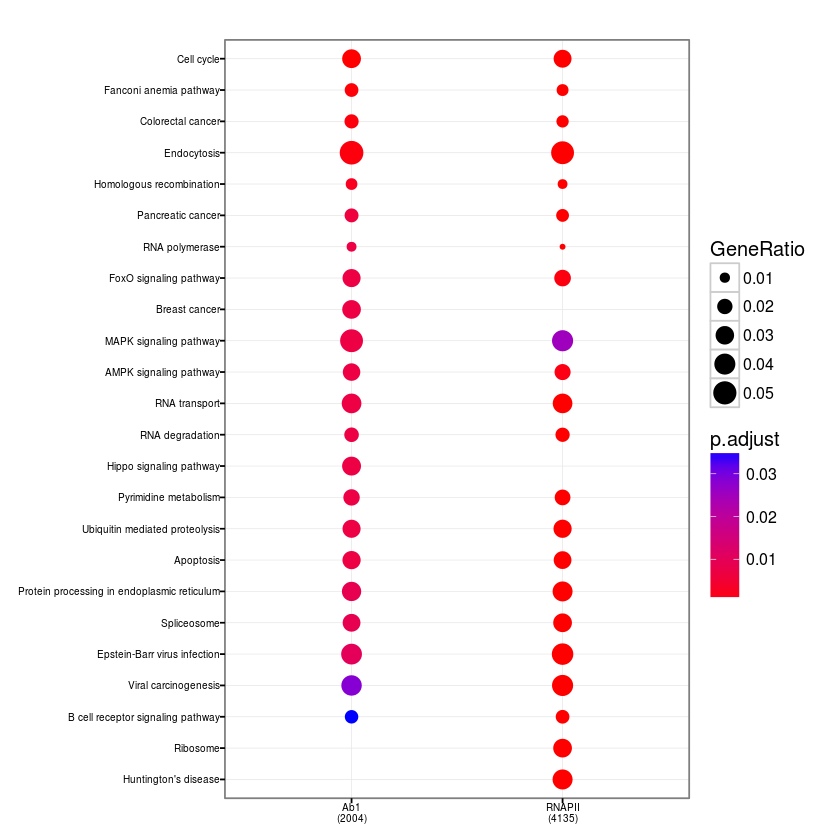

In [20]:
## KEGG Pathway enrichment
## We use the compareCluster function with the enrichKEGG method
#
# kegg.res <- compareCluster(geneList, fun = "enrichKEGG", organism='hsa')

# Since we have pre-computed results we need to load them
load(file.path(idir, "Rdata", "kegg.res.Rdata"))

# Now, we plot the top 15 kegg pathways from each peak set
dotplot(kegg.res, showCategory=15, font.size=6)

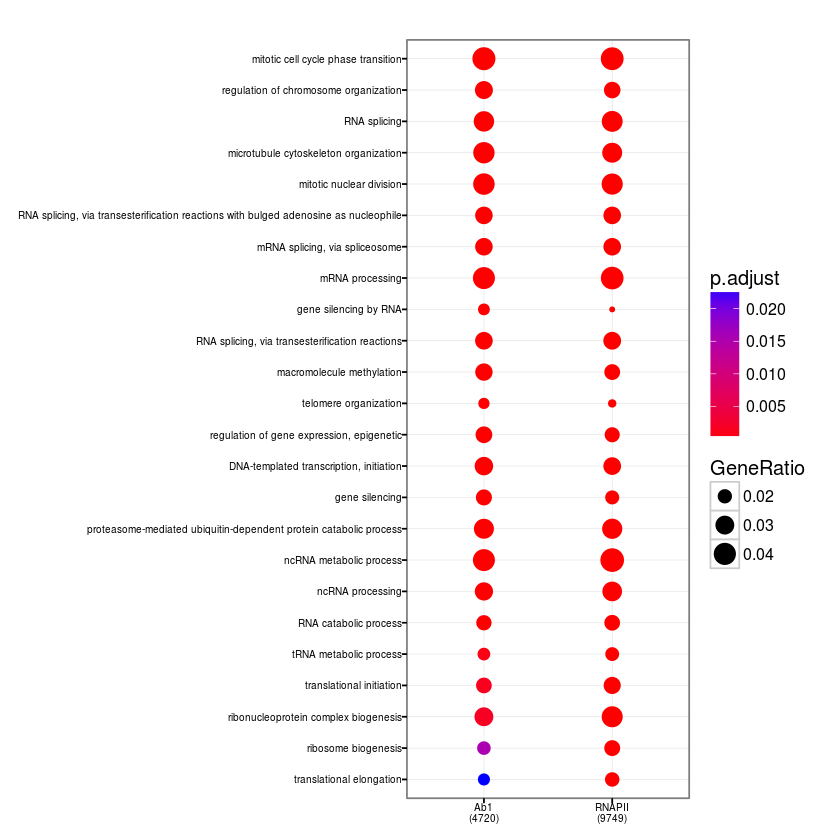

In [21]:
## GO Enrichment
## We use the compareCluster function with the enrichKEGG method
#
# bp.go.res <- compareCluster(geneList, fun = "enrichGO", ont = "BP",
#                             pvalueCutoff = 0.05, qvalueCutoff=0.05, 
#                             pAdjustMethod = "BH")

# Since we are using pre-computed data, we need to load it first
load(file.path(idir, "Rdata", "bp.go.res.Rdata"))

# Plot GO Biological Process enrichment 
dotplot(bp.go.res, showCategory = 15, font.size=6)

## Overlap of peaks and annotated genes

A common analysis to do in ChIP-Seq projects is to compare the overlap of peaks
from different experiments, or different replicates. ChIPseeker provides the `vennplot()`
function for performing these analyses and plotting.

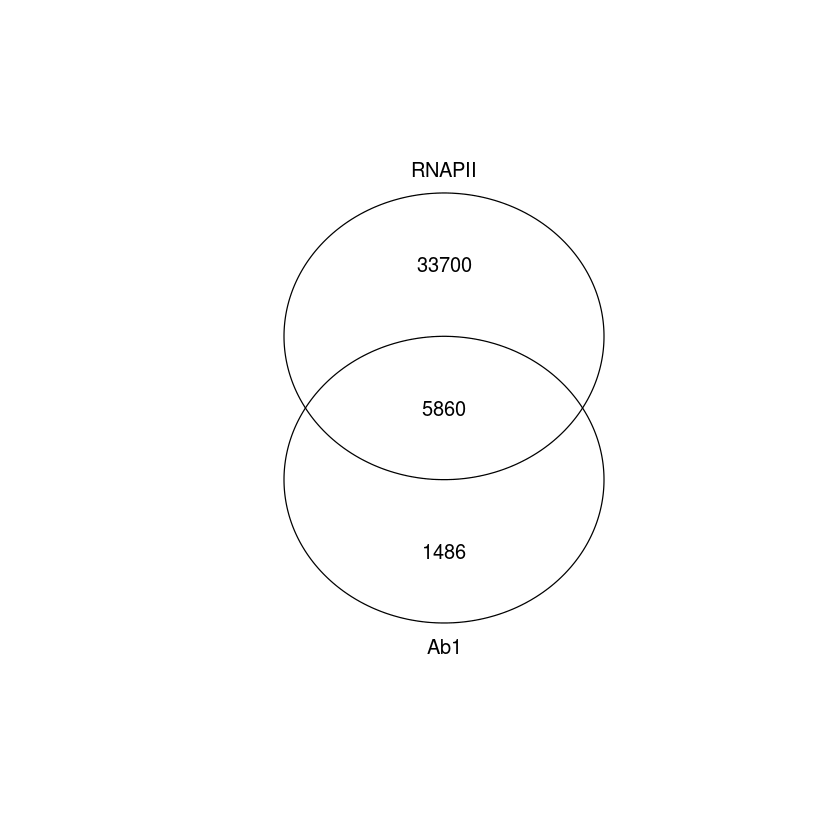

In [15]:
# Venn diagram of peak overlaps
vennplot(peaks)

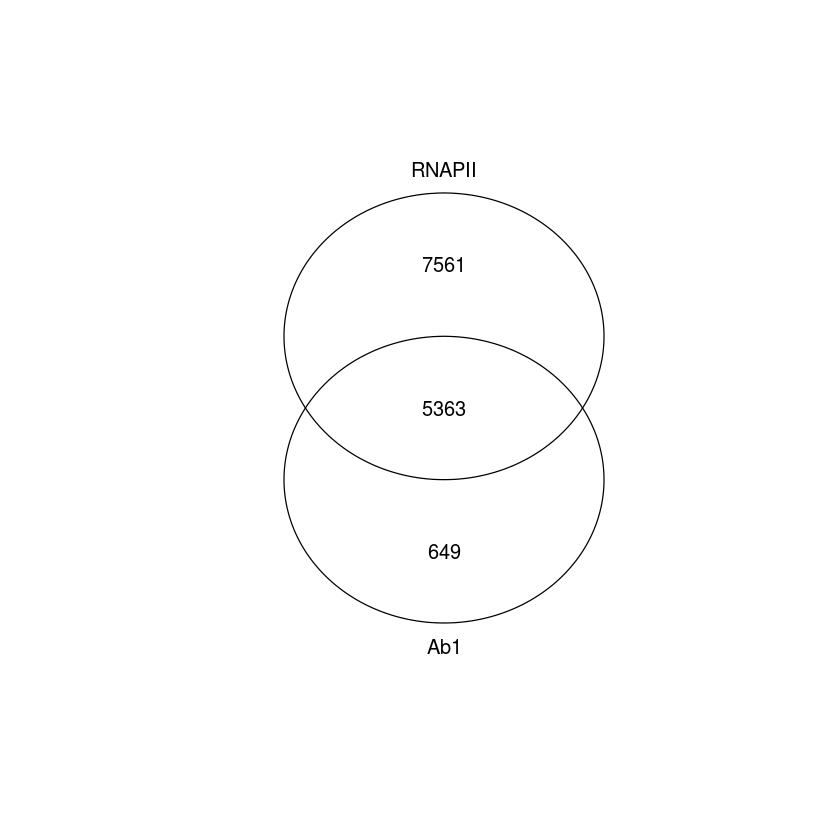

In [17]:
# Venn diagram of gene overlaps
vennplot(geneList)